# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

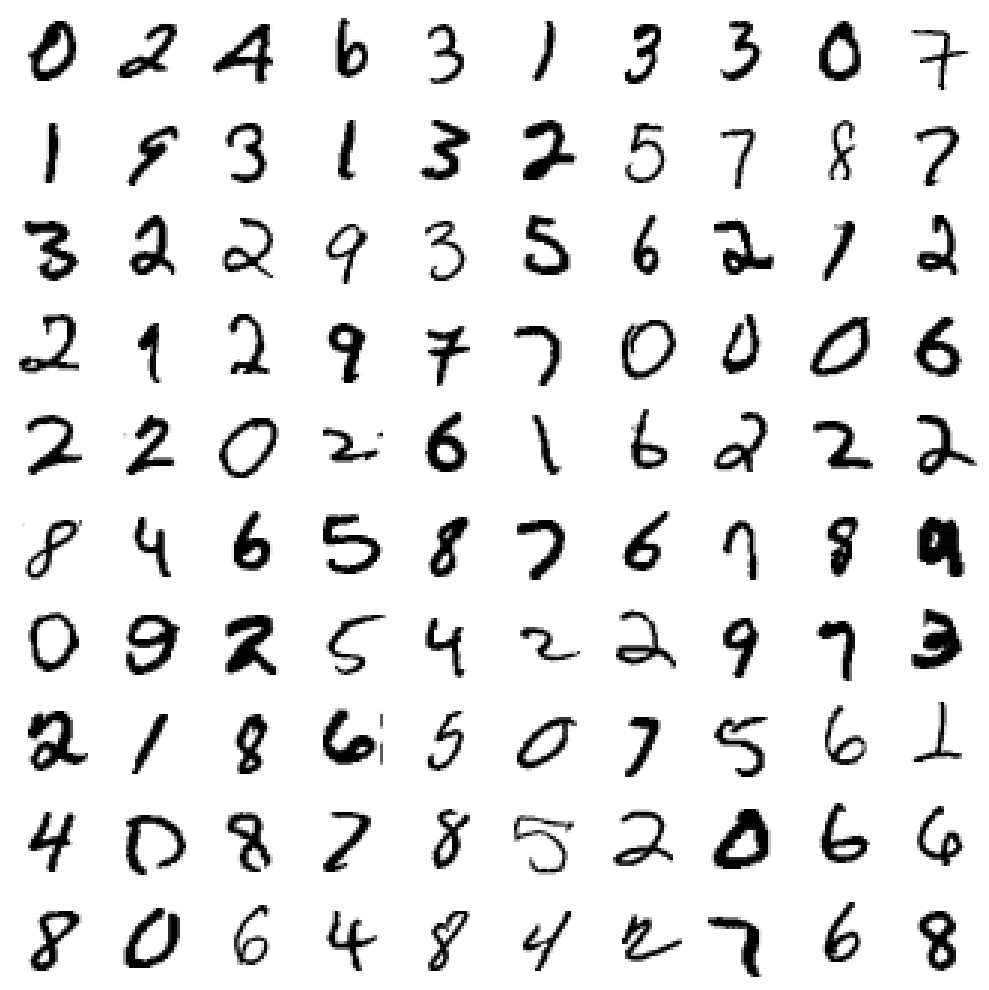

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

Compile and train the network (note that this could take a while).

In [3]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12


2025-10-01 12:15:23.961481: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 24s 51ms/step - loss: 0.2432 - accuracy: 0.9260 - val_loss: 0.0539 - val_accuracy: 0.9812
Epoch 2/12
469/469 [==============================] - 24s 52ms/step - loss: 0.0872 - accuracy: 0.9747 - val_loss: 0.0386 - val_accuracy: 0.9862
Epoch 3/12
469/469 [==============================] - 25s 52ms/step - loss: 0.0645 - accuracy: 0.9807 - val_loss: 0.0323 - val_accuracy: 0.9885
Epoch 4/12
469/469 [==============================] - 25s 54ms/step - loss: 0.0522 - accuracy: 0.9833 - val_loss: 0.0381 - val_accuracy: 0.9874
Epoch 5/12
469/469 [==============================] - 26s 55ms/step - loss: 0.0472 - accuracy: 0.9858 - val_loss: 0.0300 - val_accuracy: 0.9897
Epoch 6/12
469/469 [==============================] - 26s 56ms/step - loss: 0.0400 - accuracy: 0.9876 - val_loss: 0.0283 - val_accuracy: 0.9911
Epoch 7/12
469/469 [==============================] - 27s 57ms/step - loss: 0.0351 - accuracy: 0.9888 - val_loss: 0.0283 - val_accuracy: 0.9908
Epo

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.027792325243353844
Test accuracy: 0.991100013256073


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.kaggle.com/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://drive.google.com/file/d/1Enau6gb_BtPKCg1Yt5MZIIM18pfVEhxQ/view?usp=sharing).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


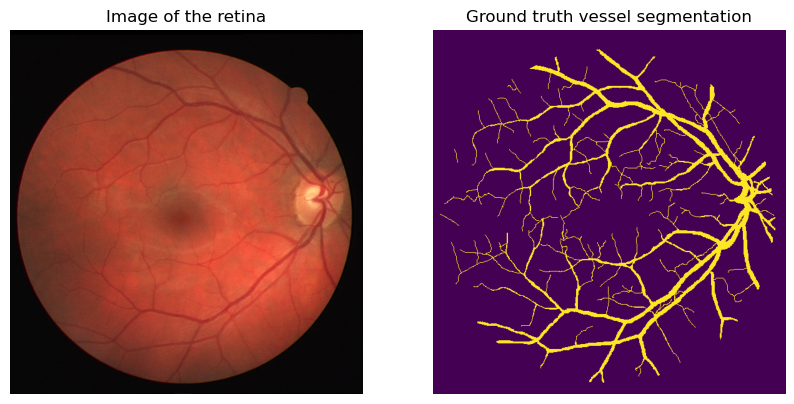

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = 'DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


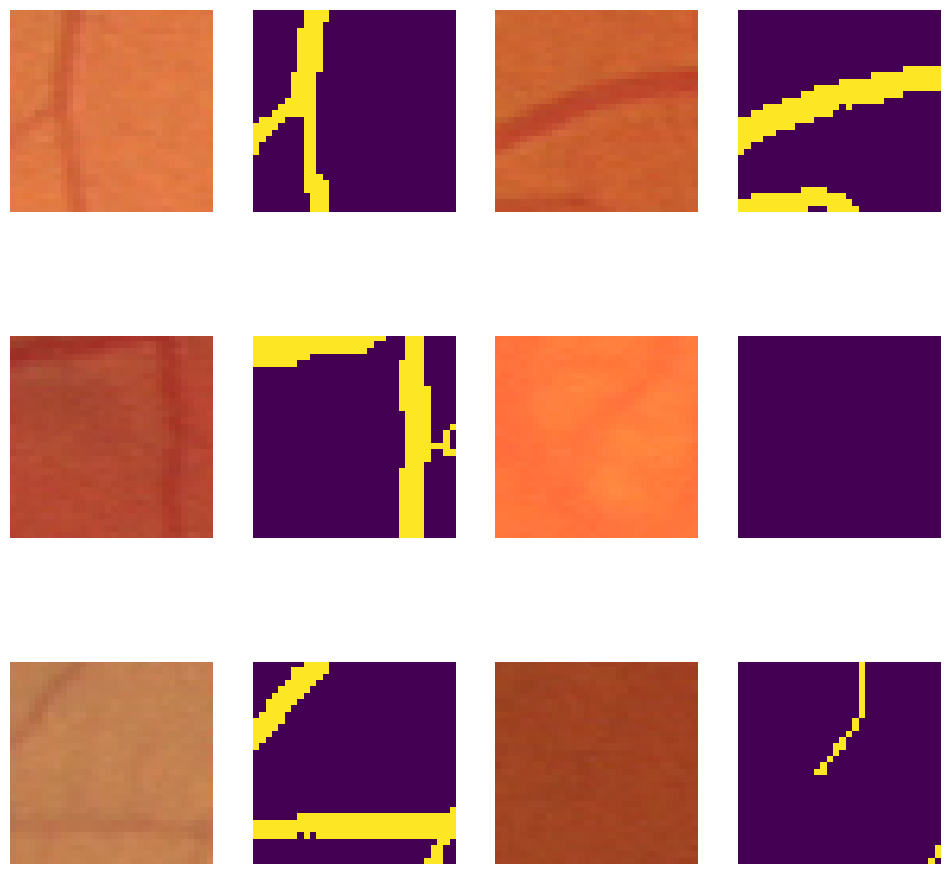

In [6]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [8]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/250


2025-10-01 12:20:33.892177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 - 14s - loss: 0.5411 - accuracy: 0.7880 - val_loss: 0.4063 - val_accuracy: 0.9136 - 14s/epoch - 277ms/step
Epoch 2/250
50/50 - 13s - loss: 0.2950 - accuracy: 0.9506 - val_loss: 0.2986 - val_accuracy: 0.9136 - 13s/epoch - 264ms/step
Epoch 3/250
50/50 - 13s - loss: 0.2125 - accuracy: 0.9571 - val_loss: 0.3694 - val_accuracy: 0.9136 - 13s/epoch - 259ms/step
Epoch 4/250
50/50 - 13s - loss: 0.1890 - accuracy: 0.9536 - val_loss: 0.2784 - val_accuracy: 0.9136 - 13s/epoch - 251ms/step
Epoch 5/250
50/50 - 13s - loss: 0.1712 - accuracy: 0.9548 - val_loss: 0.3487 - val_accuracy: 0.9142 - 13s/epoch - 257ms/step
Epoch 6/250
50/50 - 13s - loss: 0.1361 - accuracy: 0.9615 - val_loss: 0.3316 - val_accuracy: 0.9137 - 13s/epoch - 257ms/step
Epoch 7/250
50/50 - 13s - loss: 0.1207 - accuracy: 0.9633 - val_loss: 0.3376 - val_accuracy: 0.9140 - 13s/epoch - 258ms/step
Epoch 8/250
50/50 - 13s - loss: 0.1157 - accuracy: 0.9633 - val_loss: 0.2918 - val_accuracy: 0.9158 - 13s/epoch - 255ms/step
Epoch 9/250


### Visualizing the segmentation results

1/1 [==============================] - 1s 691ms/step


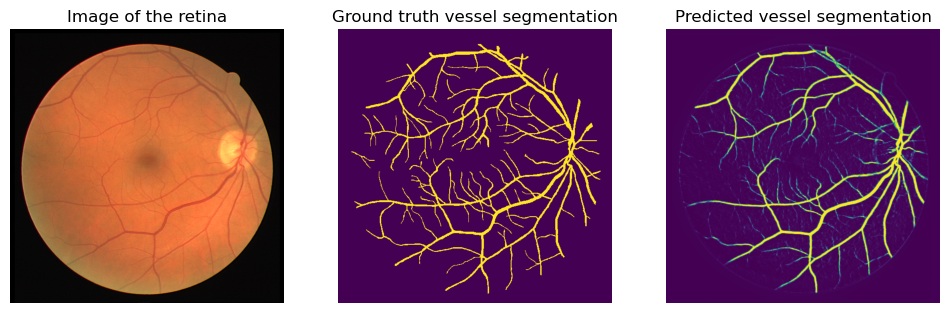

In [9]:
# run the model on one test image and show the results
from unet_utils import preprocessing, load_data

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

***Answer***:

*What do these parameters correspond to?*

The parameters in a neural network are the weights and biases learned during training. In convolutional layers, they are the filter weights that detect patterns such as edges, together with one bias per filter. In fully connected layers, they are the connection weights between all input and output neurons, plus one bias per output neuron. These parameters are the only values updated through backpropagation and represent the knobs the network tunes to learn the mapping from inputs to outputs.

*First convolutional layer (320 parameters):*

•⁠  ⁠Filter size: 3×3 

•⁠  ⁠Input channels: 1 (grayscale)

•⁠  ⁠Output channels: 32

•⁠  ⁠Parameters = (3 × 3 × 1 × 32) + 32 = 288 + 32 = *320*
  - 288 weights + 32 bias terms

*First fully connected layer (1,179,776 parameters):*

•⁠  ⁠Input size: 9216 (12×12×64 after pooling and flatten)

•⁠  ⁠Output size: 128 neurons

•⁠  ⁠Parameters = (9216 × 128) + 128 = 1,179,648 + 128 = *1,179,776*
  - 1,179,648 weights + 128 bias terms

*General formulas:*

1.⁠ ⁠*Convolutional layer:*
   Parameters = (filter_height × filter_width × input_channels × output_channels) + output_channels

2.⁠ ⁠*Fully connected layer:*
   Parameters = (input_size × output_size) + output_size

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>



## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

======= Brightness augmentation only =======
Brightness augmentation applied to 16 patches.
Mean intensity (before: 0.4777, after: 0.4304, change: -0.0473).
Mean relative change: -10.36 % (max: 34.81 %).


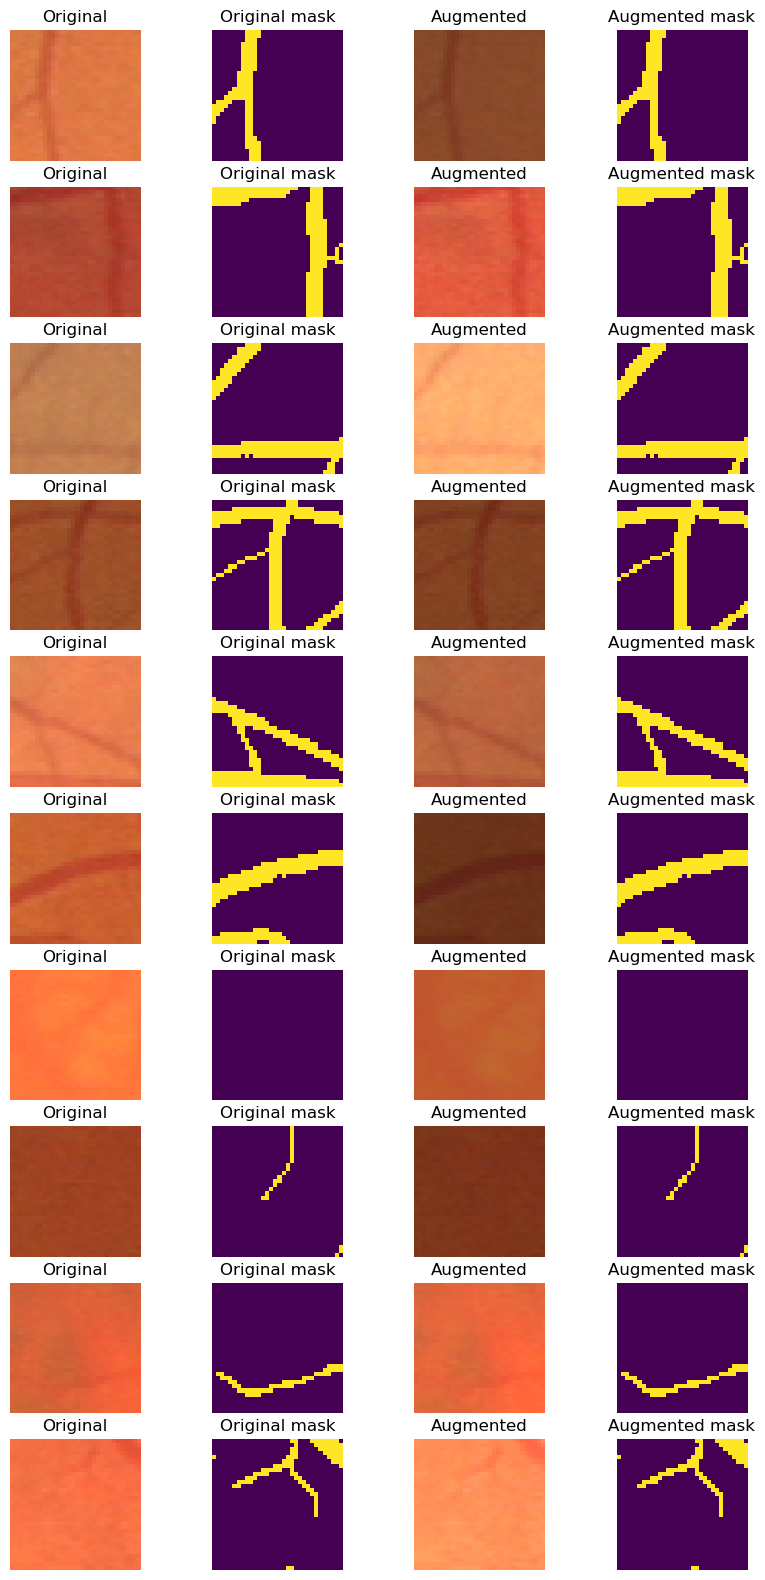

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21517771950176334..1.0000000000000002].


======= B-spline augmentation only =======
B-spline deformation applied to 16 patches.
Mean displacement (before: 0.00 px, after: 0.51 px).
Max displacement  (before: 0.00 px, after: 1.61 px).


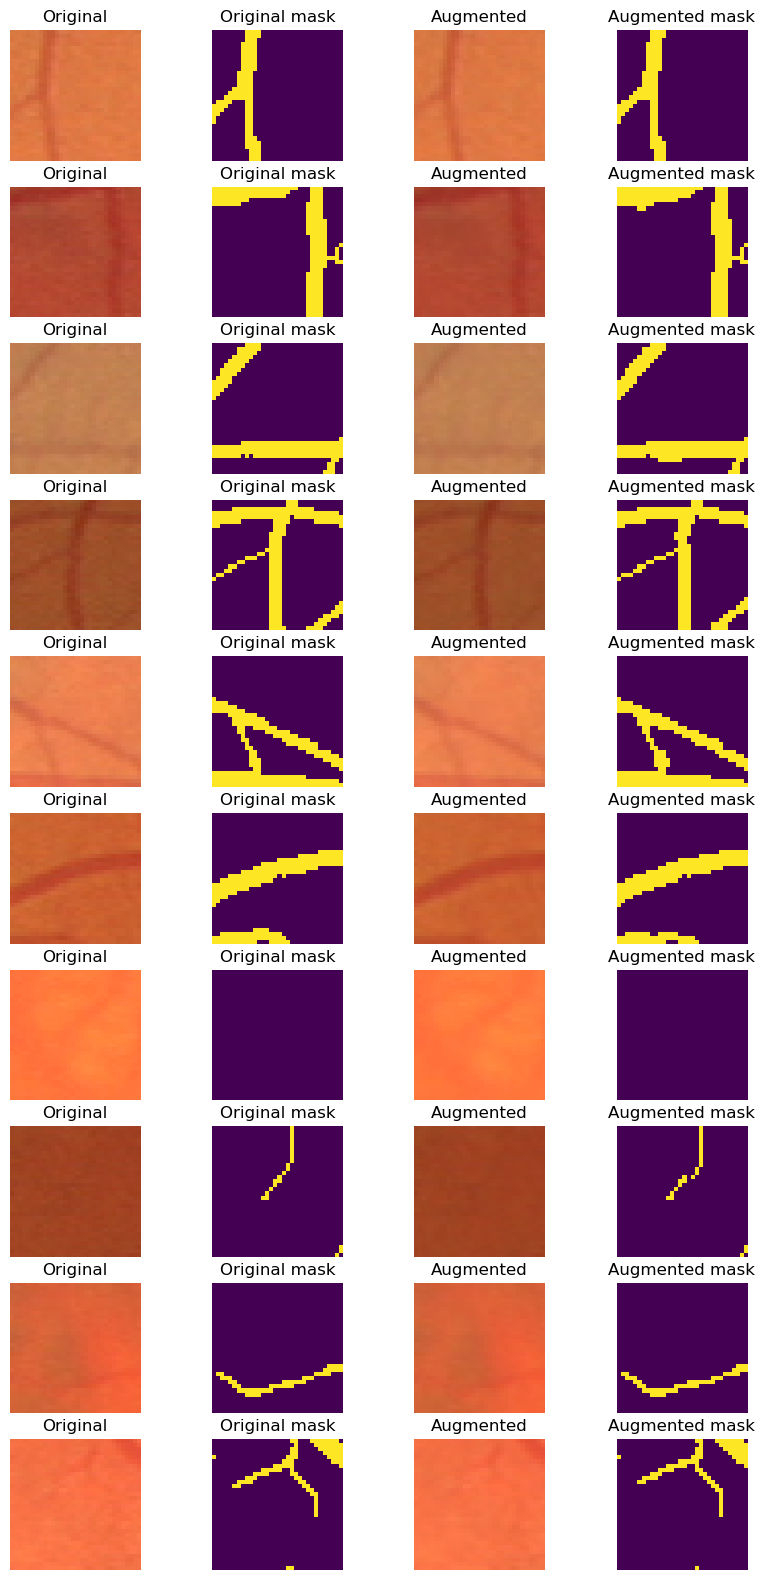

In [65]:
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter
from glob import glob
from unet_utils import load_data, extract_patches
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# location of the DRIVE dataset
data_folder = 'DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

# make a function to augment the patches by adding random brightness and/or b-spline deformations
def augment_patches(patches, segmentations, brightness=False, b_spline=False, show_preview=False):
    """Augment image patches and their corresponding segmentations.

    Args:
        patches (np.ndarray): Image patches to augment.
        segmentations (np.ndarray): Corresponding segmentation masks.
        brightness (bool, optional): Whether to apply brightness augmentation. Defaults to False.
        b_spline (bool, optional): Whether to apply B-spline deformation. Defaults to False.
        show_preview (bool, optional): Whether to show a preview of the augmentation. Defaults to False.

    Returns:
        np.ndarray: Augmented image patches.
        np.ndarray: Augmented segmentation masks.
    """
    
    patches_augmented = patches.copy()  # Start with original patches
    
    # apply random brightness changes
    if brightness:
        # Manual brightness augmentation for normalized data (0-1 range)
        lowest_brightness = 0.5
        highest_brightness = 1.5

        # keep a copy of the original patches to compute statistics
        patches_orig = patches.copy()

        brightness_factor = np.random.uniform(
            lowest_brightness, highest_brightness, size=(patches.shape[0], 1, 1, 1)
        )
        patches_augmented = patches_augmented * brightness_factor
        # Clip to valid range
        patches_augmented = np.clip(patches_augmented, 0.0, 1.0)

        # compute quantitative measures of change (per-patch mean intensity)
        mean_orig = patches_orig.mean(axis=(1, 2, 3))  # mean per patch before
        mean_new = patches_augmented.mean(axis=(1, 2, 3))  # mean per patch after
        mean_diff = mean_new - mean_orig  # absolute change (0-1 scale)

        # relative percent change, avoid division by zero by using NaN for zero denominators
        with np.errstate(divide='ignore', invalid='ignore'):
            rel_change_pct = np.where(mean_orig != 0, (mean_diff / mean_orig) * 100.0, np.nan)

        overall_mean_orig = mean_orig.mean()
        overall_mean_new = mean_new.mean()
        overall_mean_diff = mean_diff.mean()
        overall_rel_change = np.nanmean(rel_change_pct) if np.any(~np.isnan(rel_change_pct)) else np.nan
        max_abs_change = np.max(mean_diff)
        max_rel_change = np.nanmax(rel_change_pct) if np.any(~np.isnan(rel_change_pct)) else np.nan

        if show_preview:
            print(f"Brightness augmentation applied to {patches.shape[0]} patches.")
            print(f"Mean intensity (before: {overall_mean_orig:.4f}, after: {overall_mean_new:.4f}, change: {overall_mean_diff:.4f}).")
            if not np.isnan(overall_rel_change):
                print(f"Mean relative change: {overall_rel_change:.2f} % (max: {max_rel_change:.2f} %).")
            else:
                print("Mean relative change: some patches had zero mean before augmentation; relative change contains NaNs and is ignored in the mean.")

    # apply b-spline deformations
    if b_spline:
        # parameters for b-spline deformation
        alpha = 25  # scaling factor that controls the intensity of the deformation
        sigma = 8   # standard deviation of the Gaussian filter that smooths the deformation

        random_state = np.random.RandomState(None)

        # work on a copy of the segmentations so we can return the deformed masks
        segmentations_aug = segmentations.copy()

        # collect displacement statistics to quantify deformation intensity
        mean_displacements = []
        max_displacements = []

        for i in range(patches.shape[0]):
            shape = patches.shape[1:3]

            # generate random displacement fields
            dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
            dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

            # compute displacement magnitude statistics for this patch
            disp_mag = np.sqrt(dx ** 2 + dy ** 2)
            mean_displacements.append(disp_mag.mean())
            max_displacements.append(disp_mag.max())

            # create meshgrid
            x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
            indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

            # apply deformation to image channels (linear interpolation)
            for c in range(patches.shape[3]):
                patches_augmented[i, :, :, c] = map_coordinates(
                    patches_augmented[i, :, :, c], indices, order=1, mode='reflect'
                ).reshape(shape)

            # apply deformation to the mask using nearest-neighbor interpolation (order=0)
            # to preserve discrete labels
            segmentations_aug[i, :, :, 0] = map_coordinates(
                segmentations[i, :, :, 0], indices, order=0, mode='reflect'
            ).reshape(shape)

        # replace the segmentations variable with the augmented masks so the rest of the
        # function (and the returned value) uses the deformed masks
        segmentations = segmentations_aug
        
        if show_preview:
            # print a measure of how much deformation was applied (in pixels)
            if len(mean_displacements) > 0:
                overall_mean = np.mean(mean_displacements)
                overall_max = np.max(max_displacements)
                # Compare to unaugmented (which has zero displacement)
                print(f"B-spline deformation applied to {len(mean_displacements)} patches.")
                print(f"Mean displacement (before: 0.00 px, after: {overall_mean:.2f} px).")
                print(f"Max displacement  (before: 0.00 px, after: {overall_max:.2f} px).")
    
    if show_preview:

        fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 20))

        for i in range(0, 10):
            axes[i, 0].axis('off')
            axes[i, 0].imshow(patches[i])
            axes[i, 0].set_title('Original')
            axes[i, 1].axis('off')
            axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
            axes[i, 1].set_title('Original mask')
            axes[i, 2].axis('off')
            axes[i, 2].imshow(patches_augmented[i])
            axes[i, 2].set_title('Augmented')
            axes[i, 3].axis('off')
            axes[i, 3].imshow(segmentations[i][:, :, 0])
            axes[i, 3].set_title('Augmented mask')

        plt.show()

    return patches_augmented, segmentations


# augment and preview the patches with only brightness changes
print("======= Brightness augmentation only =======")
bright_aug_patches, bright_aug_segmentations = augment_patches(patches, patches_segmentations, brightness=True, b_spline=False, show_preview=True)

# augment and preview the patches with only b-spline deformations
print("======= B-spline augmentation only =======")
b_spline_aug_patches, b_spline_aug_segmentations = augment_patches(patches, patches_segmentations, brightness=False, b_spline=True, show_preview=True)

In [68]:
# we'll copy the datagenerator function here and modify it to include the augmentation functionality
def datagenerator_augmented(images, segmentations, patch_size, patches_per_im, batch_size, brightness=False, b_spline=False):
    """
    Simple data-generator to feed patches in batches to the network.
    To extract different patches each epoch, steps_per_epoch in fit_generator should be equal to nr_batches.

    :param images: Input images
    :param segmentations: Corresponding segmentations
    :param patch_size: Desired patch size
    :param patches_per_im: Amount of patches to extract per image
    :param batch_size: Number of patches per batch
    :return: Batch of patches to feed to the model
    """
    # Total number of patches generated per epoch
    total_patches = len(images) * patches_per_im
    # Amount of batches in one epoch
    nr_batches = int(np.ceil(total_patches / batch_size))

    while True:
        # Each epoch extract different patches from the training images
        x, y = extract_patches(images, segmentations, patch_size, patches_per_im, seed=np.random.randint(0, 500))
        
        # Augment the patches
        x, y = augment_patches(x, y, brightness=brightness, b_spline=b_spline, show_preview=False)

        # Feed data in batches to the network
        for idx in range(nr_batches):
            x_batch = x[idx * batch_size:(idx + 1) * batch_size]
            y_batch = y[idx * batch_size:(idx + 1) * batch_size]
            yield x_batch, y_batch

In [71]:
# copy the preprocessing function to pad the validation data from the U-Net example
# we'll also train the model on only one image to enable comparison of results with and without augmentation
from unet_utils import preprocessing
from unet_model import unet
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [72]:
# this is where our new data generator is used in which we can specify the type of augmentation
# we'll first look at brightness augmentation only
history = model.fit(datagenerator_augmented(X_train, y_train, patch_size, patches_per_im, batch_size, brightness=True, b_spline=False),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

Epoch 1/250


2025-10-02 17:28:07.610312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-10-02 17:28:07.618334: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


50/50 - 14s - loss: 0.5868 - accuracy: 0.7463 - val_loss: 0.4247 - val_accuracy: 0.9136 - 14s/epoch - 276ms/step
Epoch 2/250
50/50 - 12s - loss: 0.3283 - accuracy: 0.9341 - val_loss: 0.2957 - val_accuracy: 0.9136 - 12s/epoch - 250ms/step
Epoch 3/250
50/50 - 13s - loss: 0.2293 - accuracy: 0.9516 - val_loss: 0.2673 - val_accuracy: 0.9136 - 13s/epoch - 252ms/step
Epoch 4/250
50/50 - 13s - loss: 0.2050 - accuracy: 0.9500 - val_loss: 0.3122 - val_accuracy: 0.9136 - 13s/epoch - 252ms/step
Epoch 5/250
50/50 - 13s - loss: 0.1795 - accuracy: 0.9520 - val_loss: 0.4068 - val_accuracy: 0.9136 - 13s/epoch - 255ms/step
Epoch 6/250
50/50 - 12s - loss: 0.1689 - accuracy: 0.9518 - val_loss: 0.3758 - val_accuracy: 0.9136 - 12s/epoch - 248ms/step
Epoch 7/250
50/50 - 13s - loss: 0.1382 - accuracy: 0.9591 - val_loss: 0.3439 - val_accuracy: 0.9137 - 13s/epoch - 254ms/step
Epoch 8/250
50/50 - 13s - loss: 0.1260 - accuracy: 0.9613 - val_loss: 0.2810 - val_accuracy: 0.9193 - 13s/epoch - 253ms/step
Epoch 9/250
